# Introductory Example

This demonstrates an example using scalecast `0.18.0`. Several features explored are not available in earlier versions, so if anything is not working, try upgrading:

`pip install --upgrade scalecast`

If things are still not working, you spot a typo, or you have some other suggestion to improve functionality or document readability, open an [issue](https://github.com/mikekeith52/scalecast/issues/new) or email mikekeith52@gmail.com.

Link to dataset used in this example: https://www.kaggle.com/datasets/neuromusic/avocado-prices.  

Latest [official documentation](https://scalecast.readthedocs.io/en/latest/index.html).  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read in data
data = pd.read_csv('avocado.csv',parse_dates = ['Date'])
data = data.sort_values(['region','type','Date'])

[Univariate Forecasting](#Univariate-Forecasting)  
[Multivariate Forecasting](#Multivariate-Forecasting)  
[Transformations](#Transformations)  
[Pipelines](#Pipelines)  
[Fully Automated Pipelines](#Fully-Automated-Pipelines)  
[Scaled Automated Forecasting](#Scaled-Automated-Forecasting)  
[Exporting Results](#Exporting-Results)  

## Univariate Forecasting

### Load the `Forecaster` Object
- This is an object that can store data, run forecasts, store results, and plot. It's a UI, procedure, and set of models all-in-one.
- Forecasts in scalecast are run with a dynamic recursive approach by default, as opposed to a direct or other approach.
- [Forecaster Object Documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html).

In [3]:
from scalecast.Forecaster import Forecaster

In [4]:
volume = data.groupby('Date')['Total Volume'].sum()

In [5]:
f = Forecaster(
    y = volume,
    current_dates = volume.index,
    future_dates = 13,
)

f

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=13
    Xvars=[]
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

### Exploratory Data Analysis

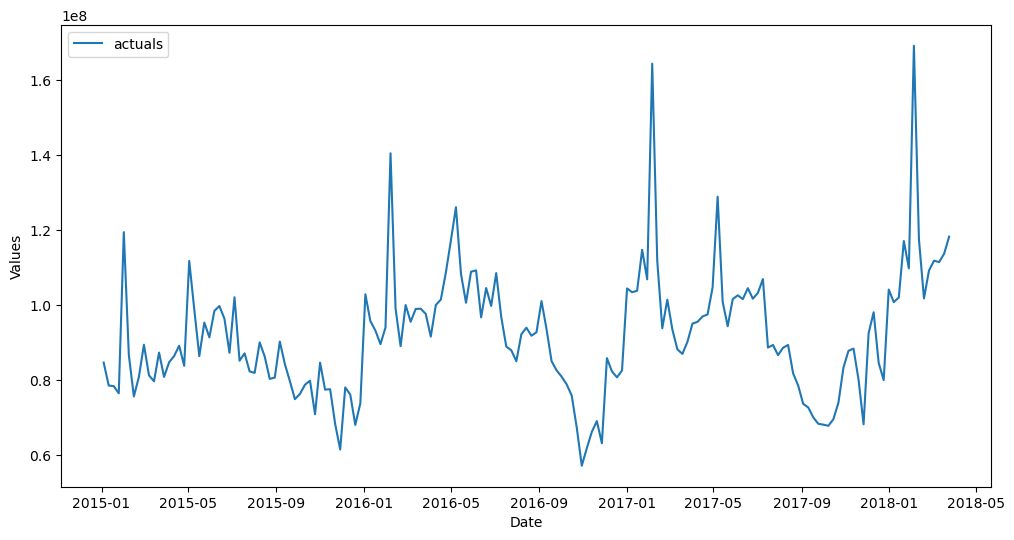

In [6]:
f.plot()
plt.show()

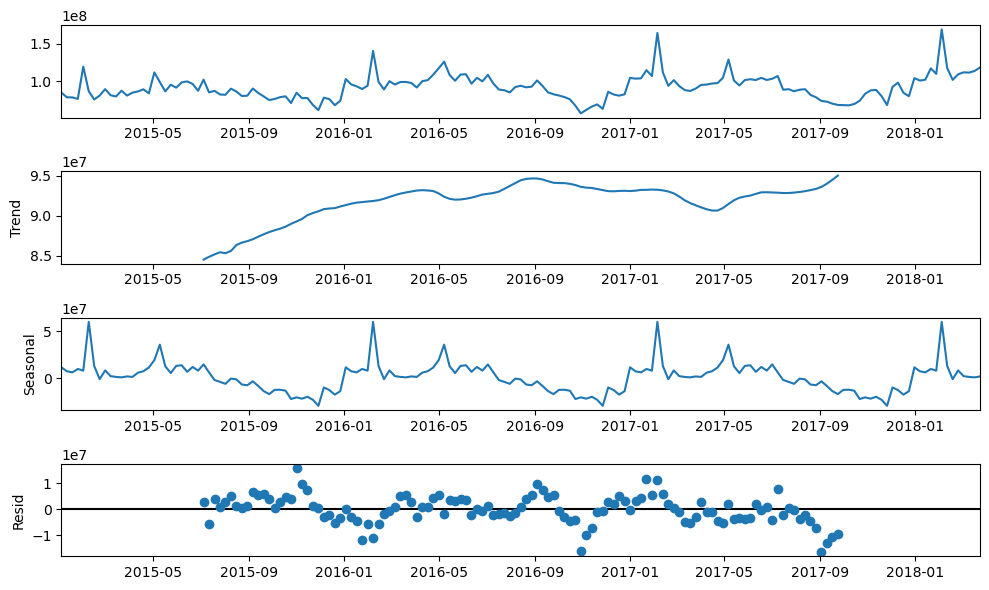

In [7]:
plt.rc("figure",figsize=(10,6))
f.seasonal_decompose().plot()
plt.show()

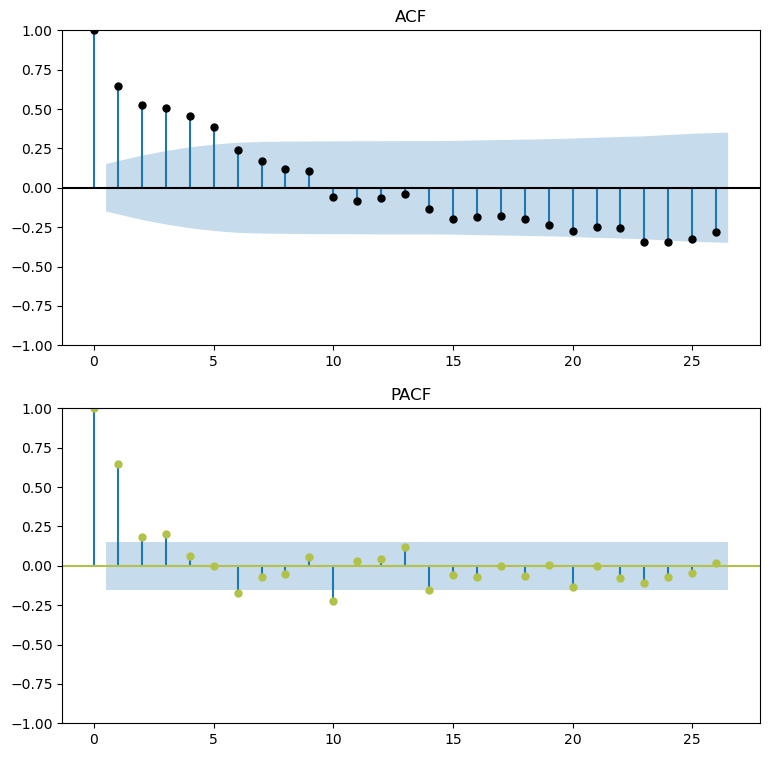

In [8]:
figs, axs = plt.subplots(2, 1,figsize=(9,9))
f.plot_acf(ax=axs[0],title='ACF',lags=26,color='black')
f.plot_pacf(ax=axs[1],title='PACF',lags=26,color='#B2C248',method='ywm')
plt.show()

### Parameterize the `Forecaster` Object

#### Set Test Length
- Starting in scalecast version 0.16.0, you can skip model testing by setting a test length of 0.
- In this example, all models will be tested on the last 15% of the observed values in the dataset.

In [9]:
f.set_test_length(.15)

#### Tell the Object to Evaluate Confidence Intervals
- This only works if there is a test set specified and it is of a sufficient size.
- See the [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.eval_cis).
- See the [example](https://scalecast-examples.readthedocs.io/en/latest/misc/cis/cis.html).

In [10]:
# default args below
f.eval_cis(
    mode = True, # tell the object to evaluate intervals
    cilevel = .95, # 95% confidence level
)

#### Specify Model Inputs

##### Trend

In [11]:
f.add_time_trend()

##### Seasonality

In [12]:
f.add_seasonal_regressors('week',raw=False,sincos=True)

##### Autoregressive Terms / Series Lags

In [13]:
f.add_ar_terms(13)

In [14]:
f

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=13
    Xvars=['t', 'weeksin', 'weekcos', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13']
    TestLength=25
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

### Run Models
- See the [available models](https://scalecast.readthedocs.io/en/latest/Forecaster/_forecast.html).
- See the [blog post](https://medium.com/towards-data-science/expand-your-time-series-arsenal-with-these-models-10c807d37558).
- The `dynamic_testing` argument for all of these will be 13 -- test-set results will then be in terms of rolling averages of 13-step forecasts, which is also our forecast length.
- The resulting forecasts from this process are not well-fit. Better forecasts are obtained once more optimization is performed in later sections.

#### Linear Scikit-Learn Models

In [15]:
f.set_estimator('mlr')
f.manual_forecast(dynamic_testing=13)

In [16]:
f.set_estimator('lasso')
f.manual_forecast(alpha=0.2,dynamic_testing=13)

In [17]:
f.set_estimator('ridge')
f.manual_forecast(alpha=0.2,dynamic_testing=13)

In [18]:
f.set_estimator('elasticnet')
f.manual_forecast(alpha=0.2,l1_ratio=0.5,dynamic_testing=13)

In [19]:
f.set_estimator('sgd')
f.manual_forecast(alpha=0.2,l1_ratio=0.5,dynamic_testing=13)

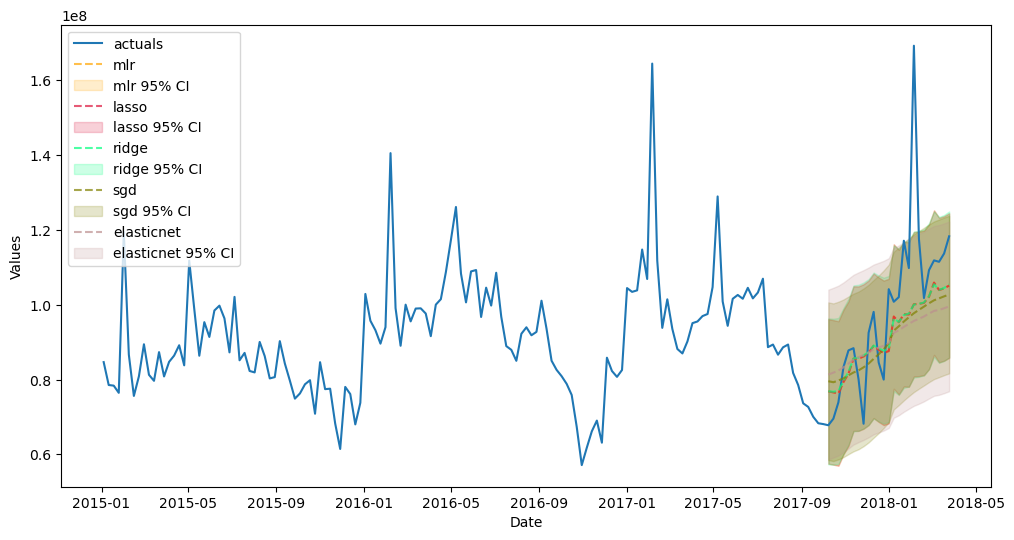

In [20]:
f.plot_test_set(ci=True,models=['mlr','lasso','ridge','elasticnet','sgd'],order_by='TestSetRMSE')
plt.show()

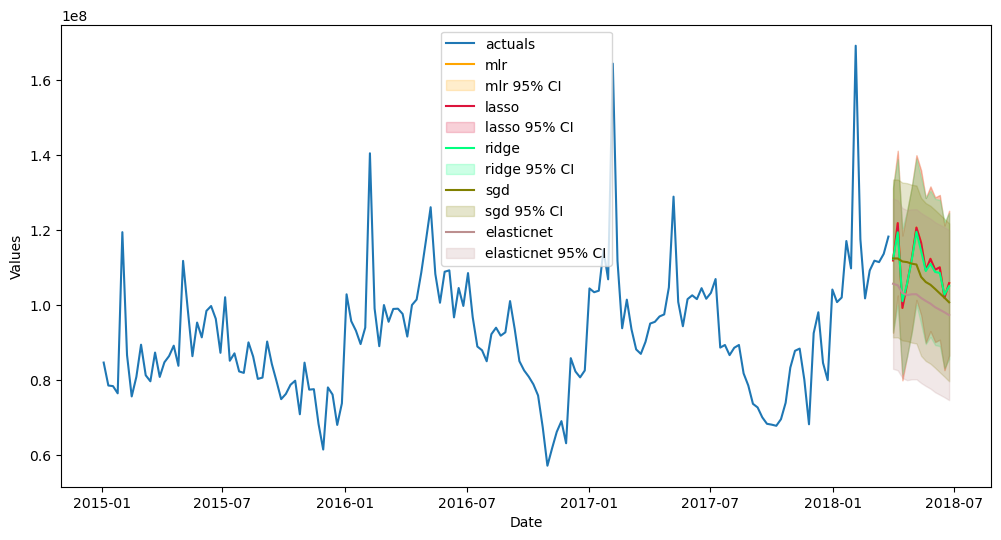

In [21]:
f.plot(ci=True,models=['mlr','lasso','ridge','elasticnet','sgd'],order_by='TestSetRMSE')
plt.show()

#### Non-linear Scikit-Learn Models

In [22]:
f.set_estimator('rf')
f.manual_forecast(max_depth=2,dynamic_testing=13)

In [23]:
f.set_estimator('gbt')
f.manual_forecast(max_depth=2,dynamic_testing=13)

In [24]:
f.set_estimator('xgboost')
f.manual_forecast(gamma=1,dynamic_testing=13)

In [25]:
f.set_estimator('lightgbm')
f.manual_forecast(max_depth=2,dynamic_testing=13)

In [26]:
f.set_estimator('catboost')
f.manual_forecast(depth=4,verbose=False,dynamic_testing=13)

Finished loading model, total used 100 iterations


In [27]:
f.set_estimator('knn')
f.manual_forecast(n_neighbors=5,dynamic_testing=13)

Finished loading model, total used 100 iterations


In [28]:
f.set_estimator('mlp')
f.manual_forecast(hidden_layer_sizes=(50,50),solver='lbfgs',dynamic_testing=13)

Finished loading model, total used 100 iterations


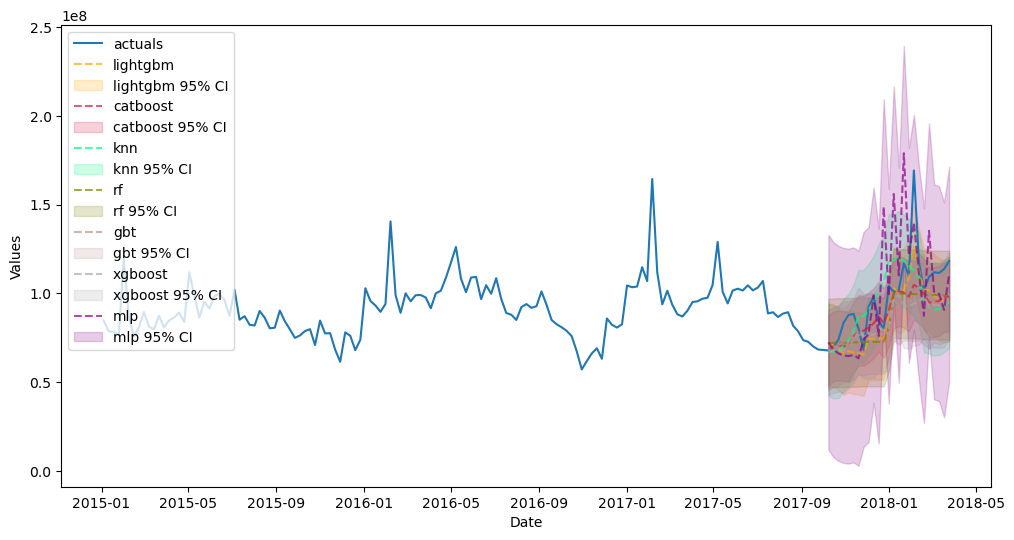

In [29]:
f.plot_test_set(
    ci=True,
    models=['rf','gbt','xgboost','lightgbm','catboost','knn','mlp'],
    order_by='TestSetRMSE'
)
plt.show()

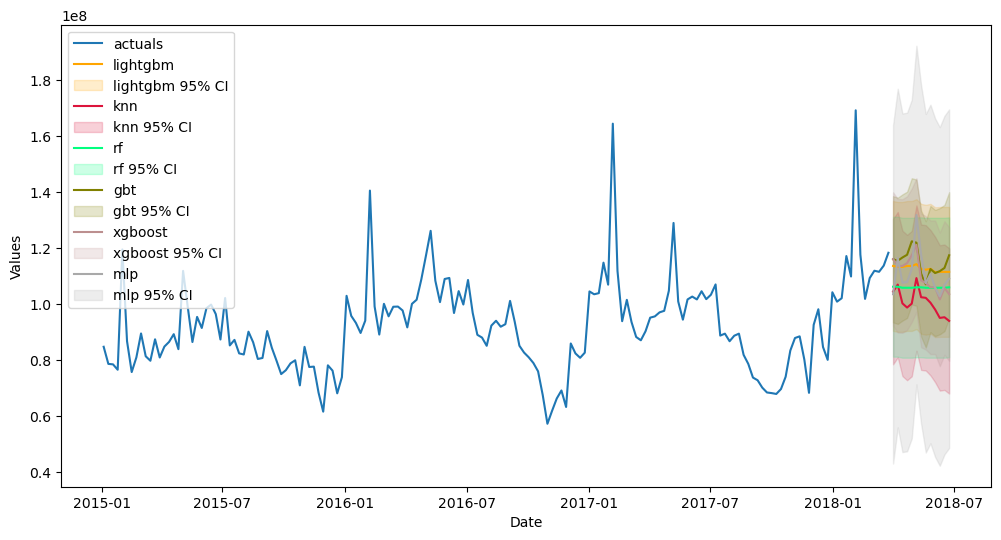

In [30]:
f.plot(ci=True,models=['rf','gbt','xgboost','lightgbm','knn','mlp'],order_by='TestSetRMSE')
plt.show()

#### Stacking Models

##### Sklearn Stacking Model

In [31]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [32]:
f.add_sklearn_estimator(StackingRegressor,'stacking')

In [33]:
estimators = [
    ('elasticnet',ElasticNet(alpha=0.2)),
    ('xgboost',XGBRegressor(gamma=1)),
    ('gbt',GradientBoostingRegressor(max_depth=2)),
]

final_estimator = LGBMRegressor()

f.set_estimator('stacking')
f.manual_forecast(
    estimators=estimators,
    final_estimator=final_estimator,
    dynamic_testing=13
)

Finished loading model, total used 100 iterations


##### Scalecast Stacking Model

In [34]:
f.add_signals(['elasticnet','lightgbm','xgboost','knn'],train_only=True)
f.set_estimator('catboost')
f.manual_forecast(call_me = 'catboost_stack',verbose=False)

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


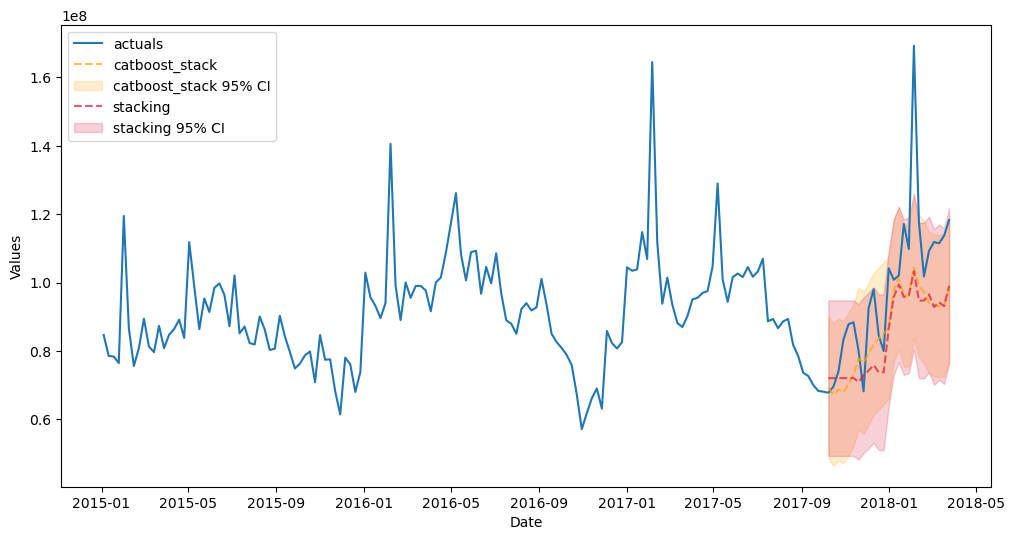

In [35]:
f.plot_test_set(models=['stacking','catboost_stack'],ci=True,order_by='TestSetRMSE')
plt.show()

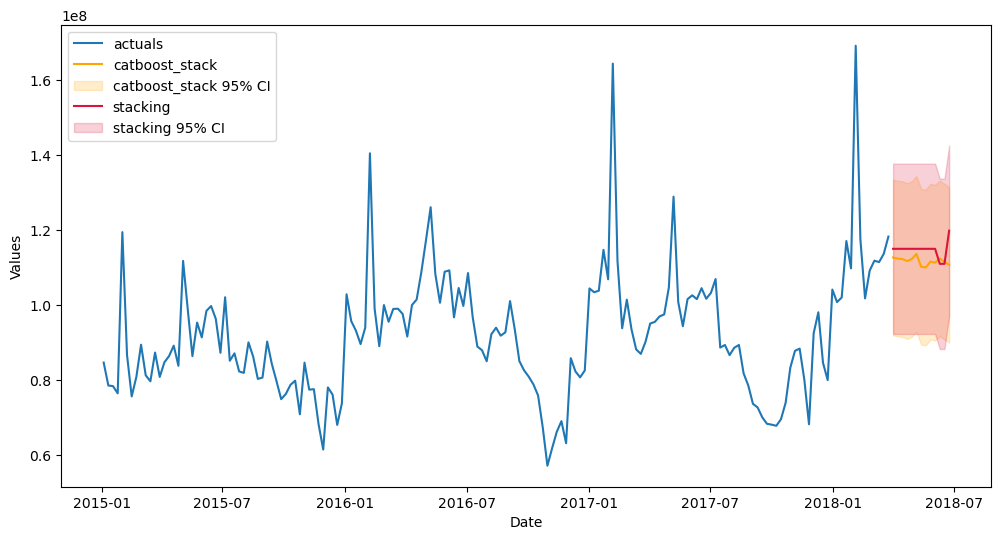

In [36]:
f.plot(models=['stacking','catboost_stack'],ci=True,order_by='TestSetRMSE')
plt.show()

#### ARIMA
- [auxmodels.auto_arima](https://scalecast.readthedocs.io/en/latest/Forecaster/Auxmodels.html#module-src.scalecast.auxmodels.auto_arima)

In [37]:
from scalecast.auxmodels import auto_arima

In [38]:
auto_arima(f,m=52)

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


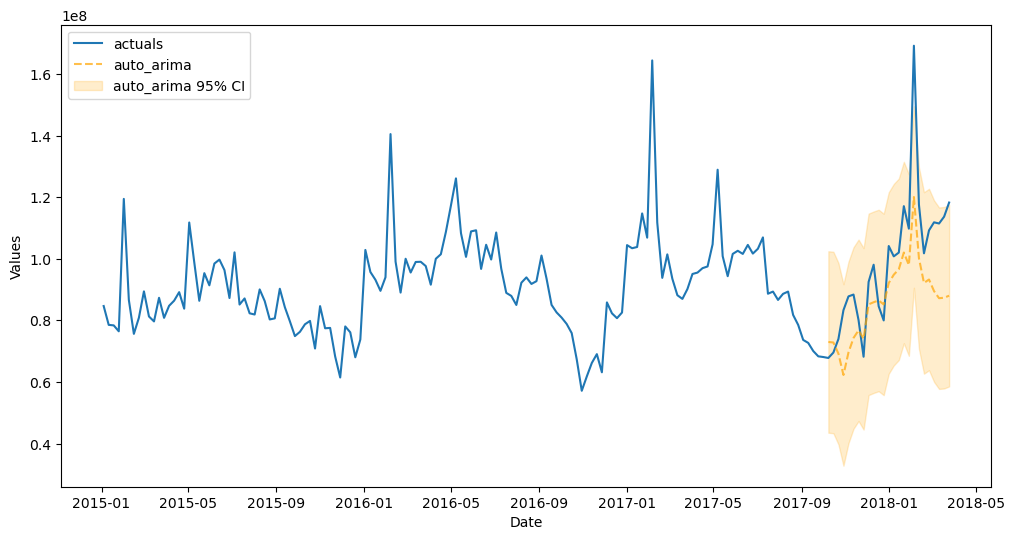

In [39]:
f.plot_test_set(models='auto_arima',ci=True)
plt.show()

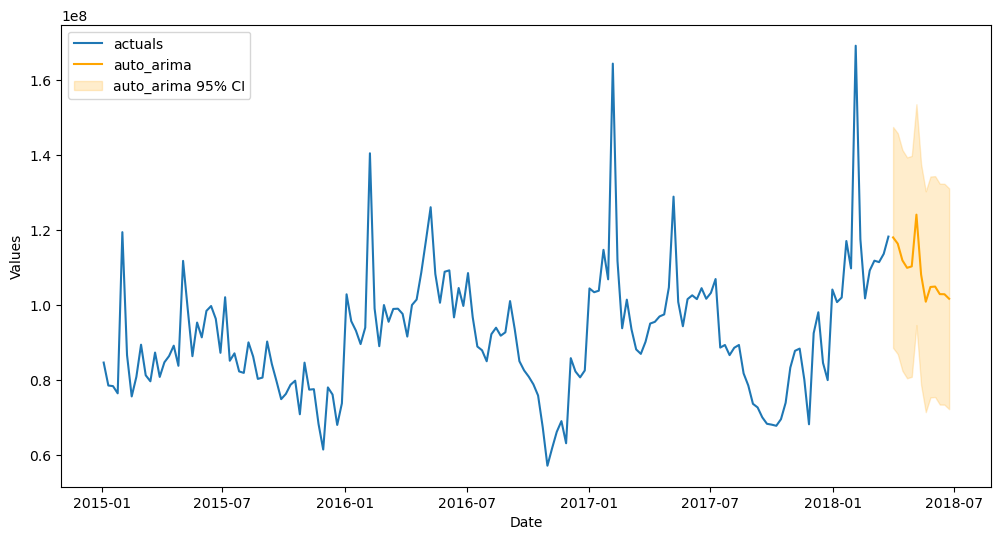

In [40]:
f.plot(models='auto_arima',ci=True)
plt.show()

#### Prophet

In [41]:
f.set_estimator('prophet')
f.manual_forecast()

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


22:14:17 - cmdstanpy - INFO - Chain [1] start processing
22:14:17 - cmdstanpy - INFO - Chain [1] done processing
22:14:17 - cmdstanpy - INFO - Chain [1] start processing
22:14:17 - cmdstanpy - INFO - Chain [1] done processing


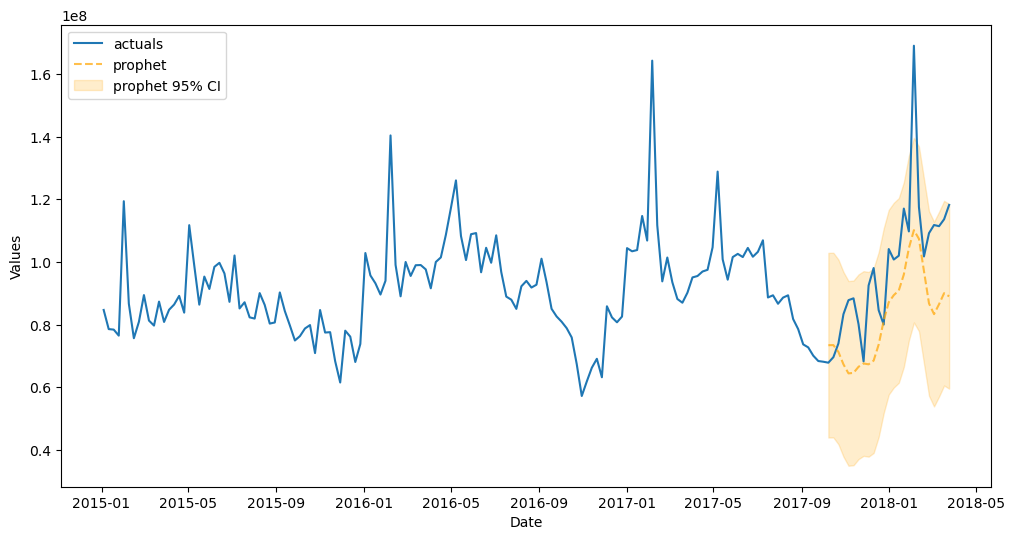

In [42]:
f.plot_test_set(models='prophet',ci=True)
plt.show()

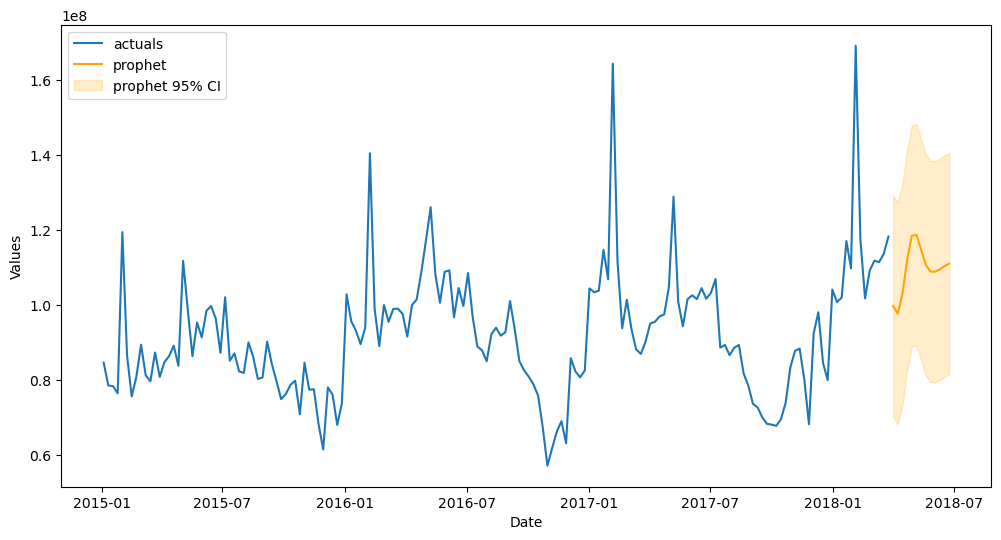

In [43]:
f.plot(models='prophet',ci=True)
plt.show()

Other univariate models available: [TBATS](https://scalecast.readthedocs.io/en/latest/Forecaster/_forecast.html#module-src.scalecast.Forecaster.Forecaster._forecast_tbats), [Holt-Winters Exponential Smoothing](https://scalecast.readthedocs.io/en/latest/Forecaster/_forecast.html#module-src.scalecast.Forecaster.Forecaster._forecast_hwes), [LSTM](https://scalecast.readthedocs.io/en/latest/Forecaster/_forecast.html#module-src.scalecast.Forecaster.Forecaster._forecast_lstm), [RNN](https://scalecast.readthedocs.io/en/latest/Forecaster/_forecast.html#module-src.scalecast.Forecaster.Forecaster._forecast_rnn), [Silverkite](https://scalecast.readthedocs.io/en/latest/Forecaster/_forecast.html#module-src.scalecast.Forecaster.Forecaster._forecast_silverkite), [Theta](https://scalecast.readthedocs.io/en/latest/Forecaster/_forecast.html#module-src.scalecast.Forecaster.Forecaster._forecast_theta).

Working on: N-Beats, N-Hits, Genetic Algorithm.

## Multivariate Forecasting

### Load the `MVForecaster` Object
- This object extends the univariate approach to several series, with many of the same plotting and reporting features available.
- [Documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/MVForecaster.html)

In [44]:
from scalecast.MVForecaster import MVForecaster

In [45]:
price = data.groupby('Date')['AveragePrice'].mean()

fvol = Forecaster(y=volume,current_dates=volume.index,future_dates=13)
fprice = Forecaster(y=price,current_dates=price.index,future_dates=13)

fvol.add_time_trend()
fvol.add_seasonal_regressors('week',raw=False,sincos=True)

mvf = MVForecaster(
    fvol,
    fprice,
    merge_Xvars='union',
    names=['volume','price'],
)

mvf

MVForecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    N_series=2
    SeriesNames=['volume', 'price']
    ForecastLength=13
    Xvars=['t', 'weeksin', 'weekcos']
    TestLength=0
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    OptimizeOn=mean
    GridsFile=MVGrids
)

### Exploratory Data Analysis

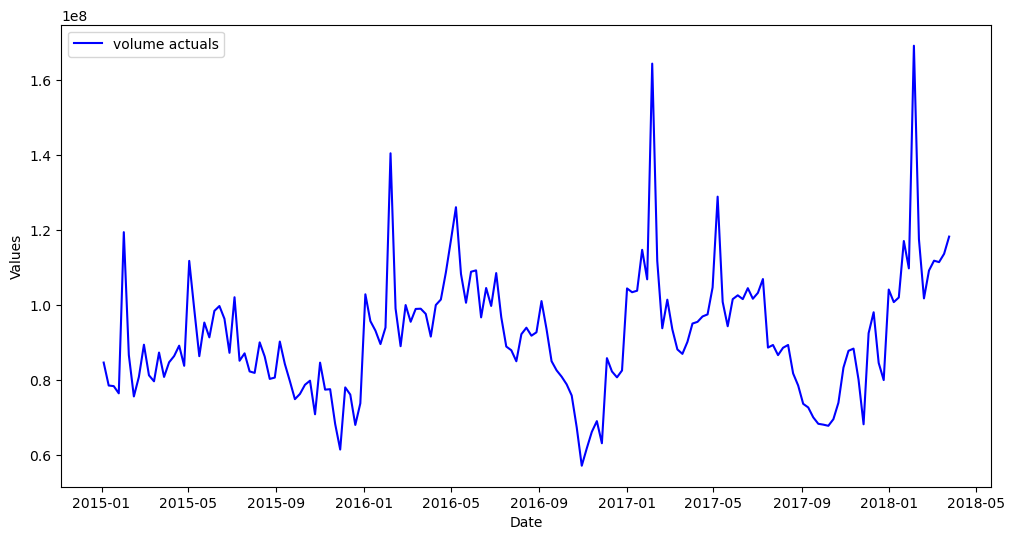

In [46]:
mvf.plot(series='volume')
plt.show()

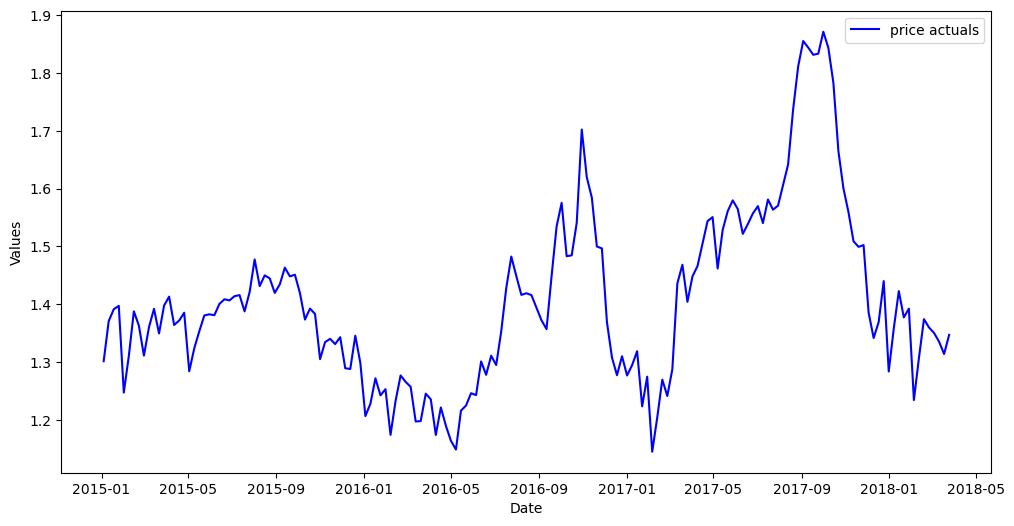

In [47]:
mvf.plot(series='price')
plt.show()

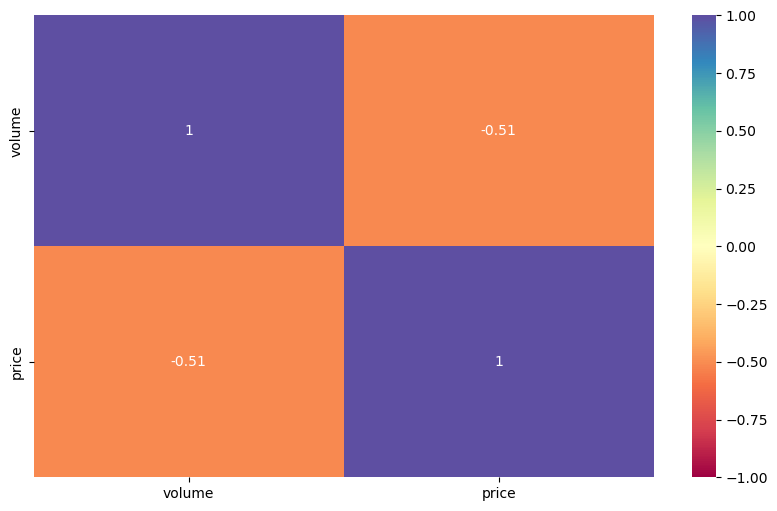

In [48]:
mvf.corr(disp='heatmap',cmap='Spectral',annot=True,vmin=-1,vmax=1)
plt.show()

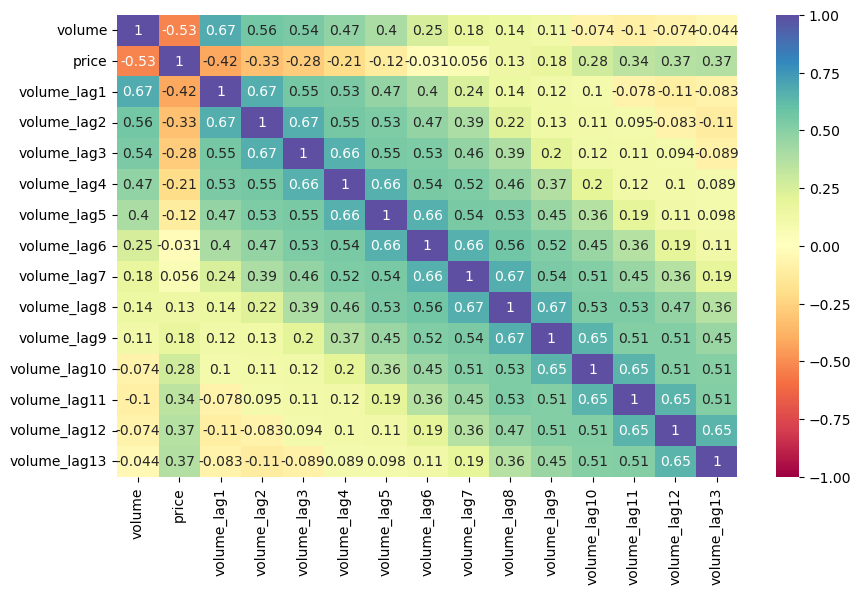

In [49]:
mvf.corr_lags(y='price',x='volume',disp='heatmap',cmap='Spectral',annot=True,vmin=-1,vmax=1,lags=13)
plt.show()

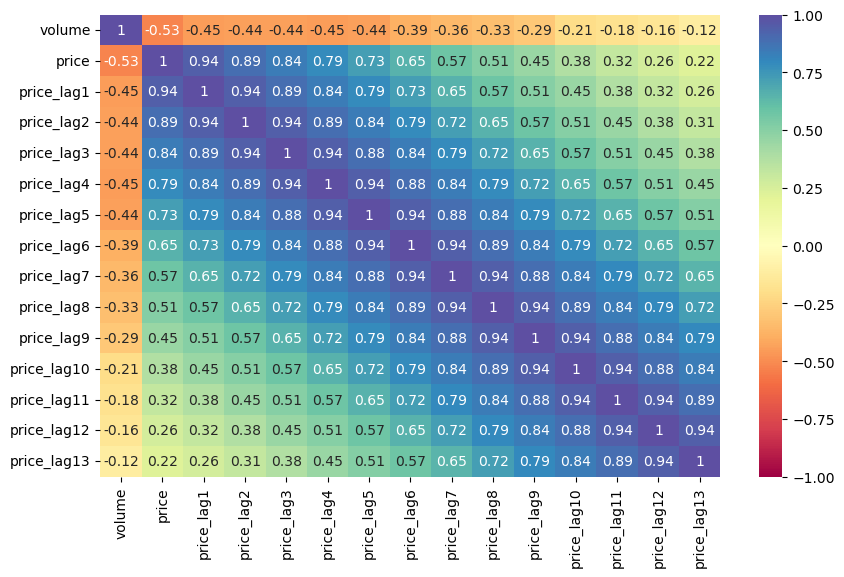

In [50]:
mvf.corr_lags(y='volume',x='price',disp='heatmap',cmap='Spectral',annot=True,vmin=-1,vmax=1,lags=13)
plt.show()

### Parameterize the `MVForecaster` Object
- Starting in scalecast version 0.16.0, you can skip model testing by setting a test length of 0.
- In this example, all models will be tested on the last 15% of the observed values in the dataset.
- We will also have model optimization select hyperparemeters based on what predicts the volume series, rather than the price series, or an average of the two (which is the default), best.
- [Custom optimization](https://scalecast.readthedocs.io/en/latest/Forecaster/MVForecaster.html#src.scalecast.MVForecaster.MVForecaster.add_optimizer_func) functions are available.

In [51]:
mvf.set_test_length(.15)
mvf.set_optimize_on('volume') # we care more about predicting volume and price is just used to make those predictions more accurate
# by default, the optimizer uses an average scoring of all series in the MVForecaster object
mvf.eval_cis() # tell object to evaluate cis

mvf

MVForecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    N_series=2
    SeriesNames=['volume', 'price']
    ForecastLength=13
    Xvars=['t', 'weeksin', 'weekcos']
    TestLength=25
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    OptimizeOn=volume
    GridsFile=MVGrids
)

### Run Models
- Uses scikit-learn models and APIs only.
- See the adapted [VECM model](https://scalecast.readthedocs.io/en/latest/Forecaster/Auxmodels.html#vecm) for this object.

#### ElasticNet

In [52]:
mvf.set_estimator('elasticnet')
mvf.manual_forecast(alpha=0.2,dynamic_testing=13,lags=13)

#### XGBoost

In [53]:
mvf.set_estimator('xgboost')
mvf.manual_forecast(gamma=1,dynamic_testing=13,lags=13)

#### MLP Stack
- [auxmodels.mlp_stack](https://scalecast.readthedocs.io/en/latest/Forecaster/Auxmodels.html#module-src.scalecast.auxmodels.mlp_stack)

In [54]:
from scalecast.auxmodels import mlp_stack

In [55]:
mvf.export('model_summaries')

,Series,ModelNickname,Estimator,Xvars,HyperParams,Lags,Observations,DynamicallyTested,TestSetLength,ValidationMetric,ValidationMetricValue,InSampleRMSE,InSampleMAPE,InSampleMAE,InSampleR2,TestSetRMSE,TestSetMAPE,TestSetMAE,TestSetR2
0,volume,elasticnet,elasticnet,"[t, weeksin, weekcos]",{'alpha': 0.2},13,169,13,25,NaN,NaN,1.197603e+07,0.088917,8.206334e+06,0.486109,1.869490e+07,0.118172,1.282436e+07,0.248765
1,volume,xgboost,xgboost,"[t, weeksin, weekcos]",{'gamma': 1},13,169,13,25,NaN,NaN,3.416022e+02,0.000003,2.591667e+02,1.000000,2.260606e+07,0.173554,1.644149e+07,-0.098447
2,price,elasticnet,elasticnet,"[t, weeksin, weekcos]",{'alpha': 0.2},13,169,13,25,NaN,NaN,1.560728e-01,0.084080,1.199107e-01,0.000000,1.522410e-01,0.071282,1.088633e-01,-0.048569
3,price,xgboost,xgboost,"[t, weeksin, weekcos]",{'gamma': 1},13,169,13,25,NaN,NaN,1.141005e-01,0.058215,8.255353e-02,0.465533,1.291758e-01,0.057186,8.791148e-02,0.245089


In [56]:
mlp_stack(mvf,model_nicknames=['elasticnet','xgboost'],lags=13)

In [57]:
mvf.set_best_model(determine_best_by='TestSetRMSE')

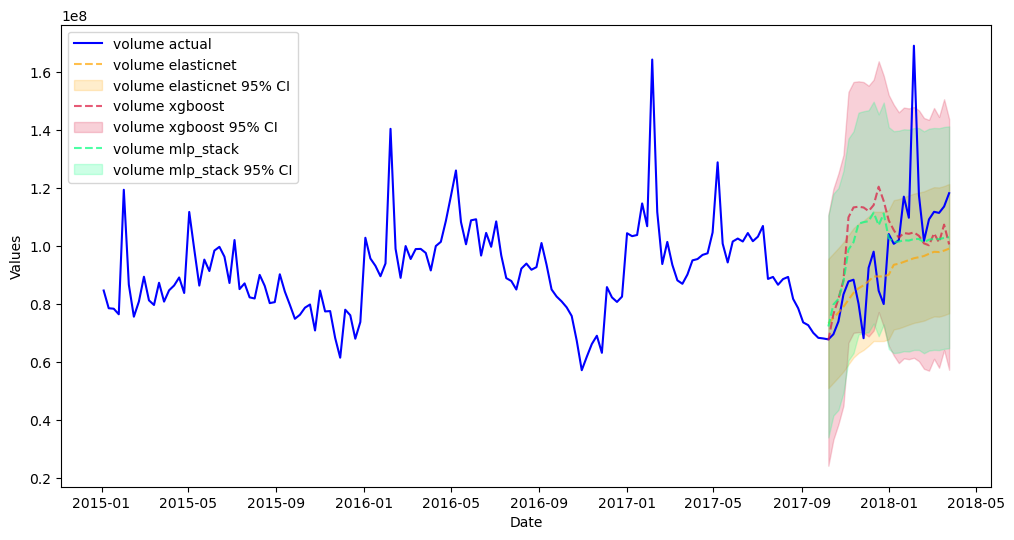

In [58]:
mvf.plot_test_set(ci=True,series='volume',put_best_on_top=True)
plt.show()

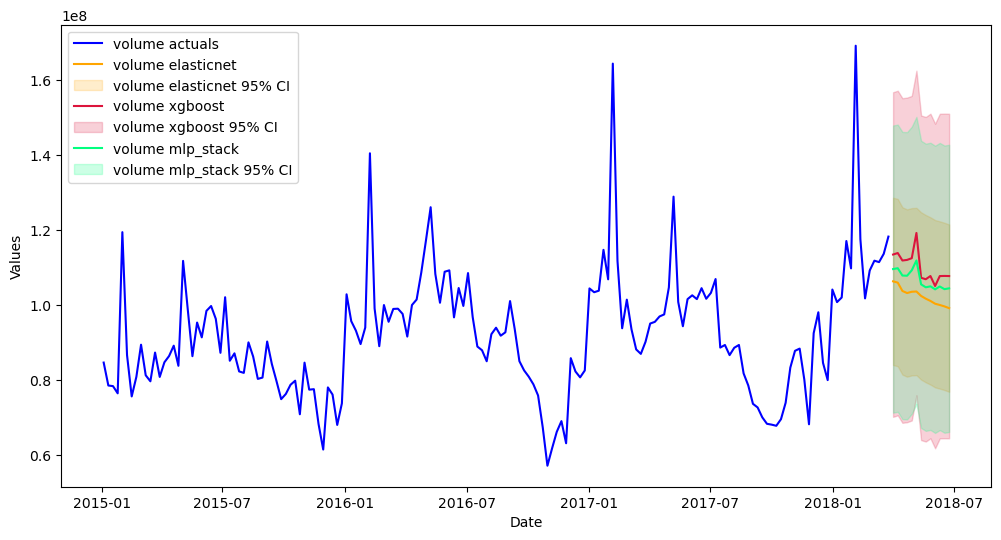

In [59]:
mvf.plot(ci=True,series='volume',put_best_on_top=True)
plt.show()

Probabalistic forecasting for creating confidence intervals is currently being worked on in the MVForecaster object, but until that is done, the backtested interval also works well:

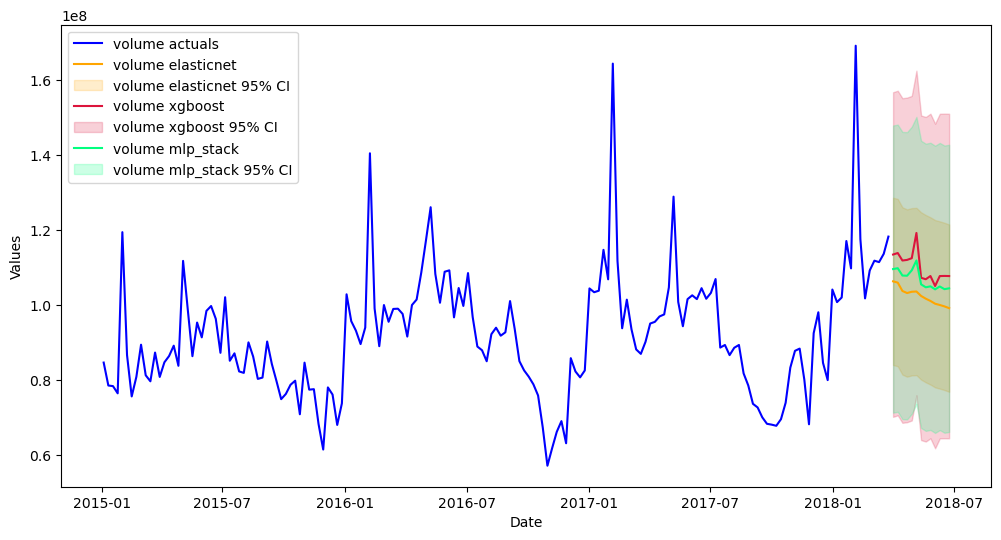

In [60]:
mvf.plot(ci=True,series='volume',put_best_on_top=True)
plt.show()

### Break Back into Forecaster Objects
- You can then add univariate models to these objects to compare with the models run multivariate.

In [61]:
from scalecast.util import break_mv_forecaster

In [62]:
fvol, fprice = break_mv_forecaster(mvf)

In [63]:
fvol

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=13
    Xvars=[]
    TestLength=25
    ValidationMetric=rmse
    ForecastsEvaluated=['elasticnet', 'xgboost', 'mlp_stack']
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [64]:
fprice

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=13
    Xvars=[]
    TestLength=25
    ValidationMetric=rmse
    ForecastsEvaluated=['elasticnet', 'xgboost', 'mlp_stack']
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

## Transformations
- One of the most effective way to boost forecasting power is with transformations.
- Transformations include:
  - [Log](https://scalecast.readthedocs.io/en/latest/Forecaster/SeriesTransformer.html#src.scalecast.SeriesTransformer.SeriesTransformer.LogTransform)
  - Scaling
    - [Standard](https://scalecast.readthedocs.io/en/latest/Forecaster/SeriesTransformer.html#src.scalecast.SeriesTransformer.SeriesTransformer.ScaleTransform)
    - [MinMax](https://scalecast.readthedocs.io/en/latest/Forecaster/SeriesTransformer.html#src.scalecast.SeriesTransformer.SeriesTransformer.MinMaxTransform)
  - [Differencing](https://scalecast.readthedocs.io/en/latest/Forecaster/SeriesTransformer.html#src.scalecast.SeriesTransformer.SeriesTransformer.DiffTransform)
  - [Detrending](https://scalecast.readthedocs.io/en/latest/Forecaster/SeriesTransformer.html#src.scalecast.SeriesTransformer.SeriesTransformer.DetrendTransform)
  - [Custom Functions](https://scalecast.readthedocs.io/en/latest/Forecaster/SeriesTransformer.html#src.scalecast.SeriesTransformer.SeriesTransformer.Transform)
- All transformations have a corresponding revert function.
- See the [blog post](https://medium.com/towards-data-science/time-series-transformations-and-reverting-made-easy-f4f768c18f63).

In [65]:
from scalecast.SeriesTransformer import SeriesTransformer

In [66]:
f_trans = Forecaster(y=volume,current_dates=volume.index,future_dates=13)

In [67]:
f_trans.set_test_length(.15)
f_trans.set_validation_length(13)

In [68]:
transformer = SeriesTransformer(f_trans)

In [69]:
# these will all be reverted later after forecasts have been called
f_trans = transformer.DiffTransform(1)
f_trans = transformer.DiffTransform(52)
f_trans = transformer.DetrendTransform()

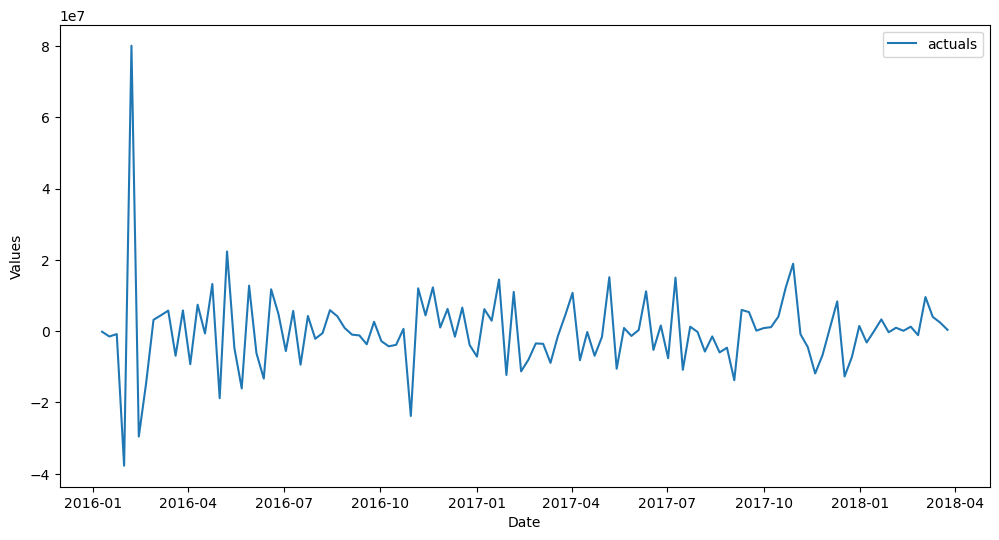

In [70]:
f_trans.plot()
plt.show()

In [71]:
f_trans.add_time_trend()
f_trans.add_seasonal_regressors('week',sincos=True,raw=False)
f_trans.add_ar_terms(13)

In [72]:
f_trans.set_estimator('xgboost')
f_trans.manual_forecast(gamma=1,dynamic_testing=13)

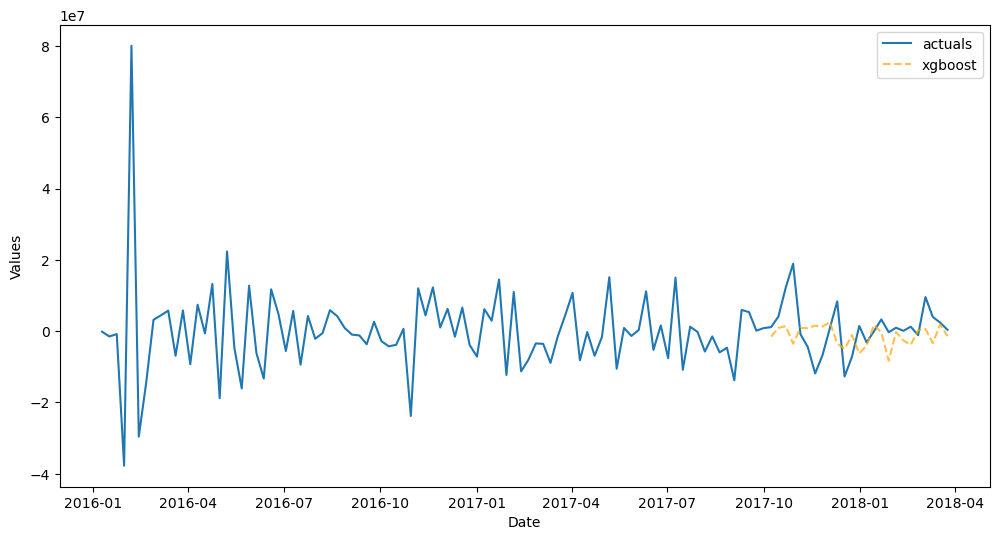

In [73]:
f_trans.plot_test_set()
plt.show()

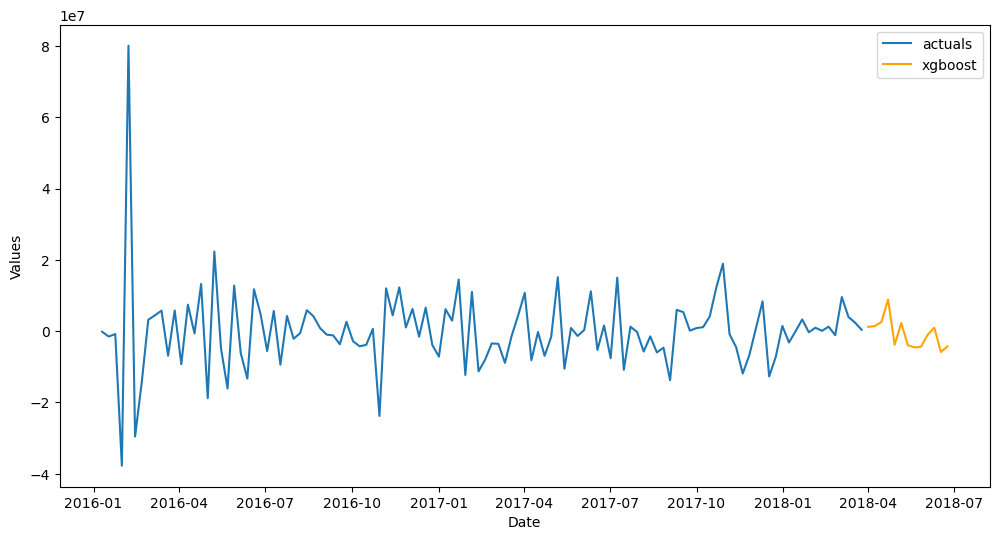

In [74]:
f_trans.plot()
plt.show()

In [75]:
# call revert functions in the opposite order as how they were called when transforming
f_trans = transformer.DetrendRevert()
f_trans = transformer.DiffRevert(52)
f_trans = transformer.DiffRevert(1)

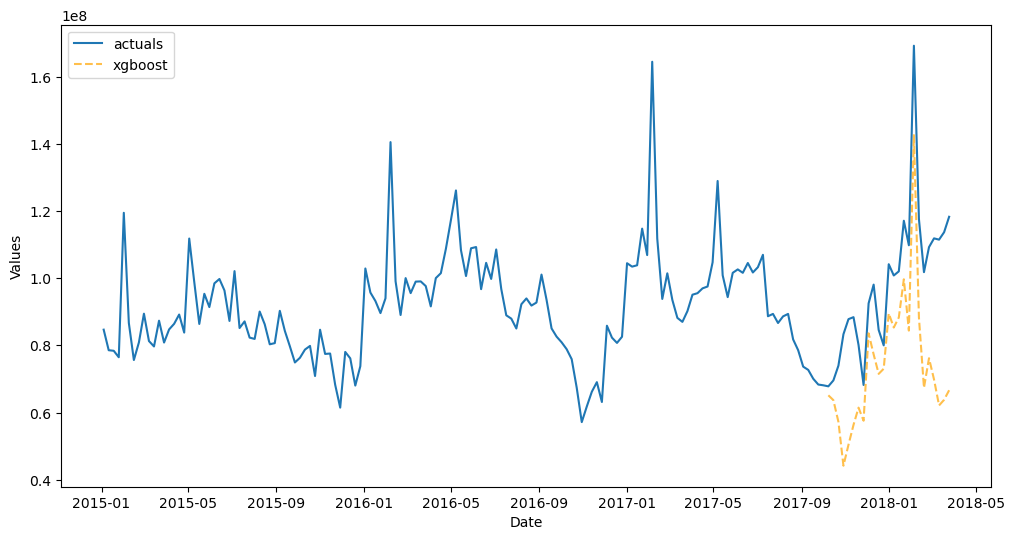

In [76]:
f_trans.plot_test_set()
plt.show()

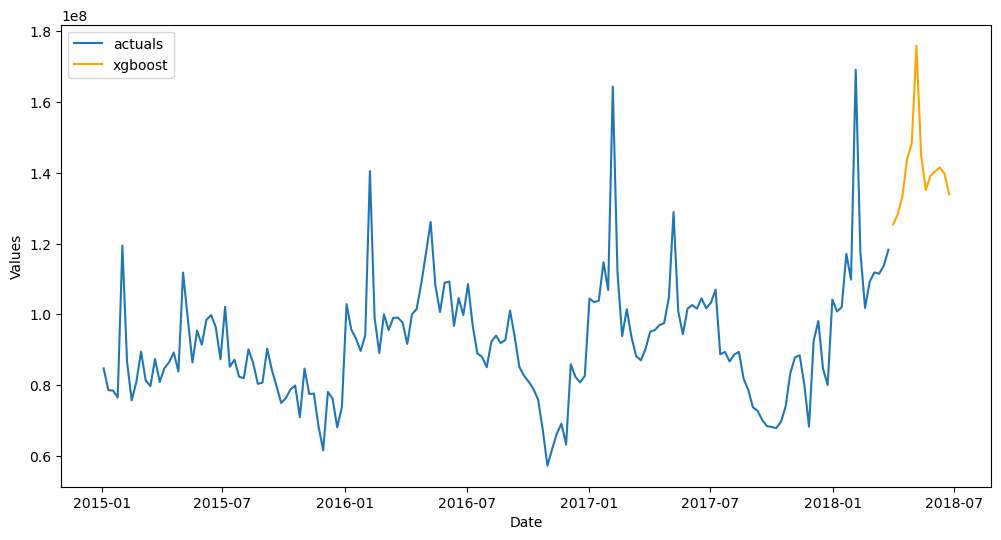

In [77]:
f_trans.plot()
plt.show()

## Pipelines
- These are objects similar to scikit-learn pipelines that offer readable and streamlined code for transforming, forecasting, and reverting.
- See the [Pipeline object documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Pipeline.html).

In [78]:
from scalecast.Pipeline import Transformer, Reverter, Pipeline, MVPipeline

In [79]:
f_pipe = Forecaster(y=volume,current_dates=volume.index,future_dates=13)
f_pipe.set_test_length(.15)

In [80]:
def forecaster(f):
    f.add_time_trend()
    f.add_seasonal_regressors('week',raw=False,sincos=True)
    f.add_ar_terms(13)
    f.set_estimator('lightgbm')
    f.manual_forecast(max_depth=2)

In [81]:
transformer = Transformer(
    transformers = [
        ('DiffTransform',1),
        ('DiffTransform',52),
        ('DetrendTransform',)
    ]
)

reverter = Reverter(
    reverters = [
        ('DetrendRevert',),
        ('DiffRevert',52),
        ('DiffRevert',1)
    ],
    base_transformer = transformer,
)

In [82]:
reverter

Reverter(
  reverters = [
    ('DetrendRevert',),
    ('DiffRevert', 52),
    ('DiffRevert', 1)
  ],
  base_transformer = Transformer(
  transformers = [
    ('DiffTransform', 1),
    ('DiffTransform', 52),
    ('DetrendTransform',)
  ]
)
)

In [83]:
pipeline = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Forecast',forecaster),
        ('Revert',reverter),
    ]
)

f_pipe = pipeline.fit_predict(f_pipe)

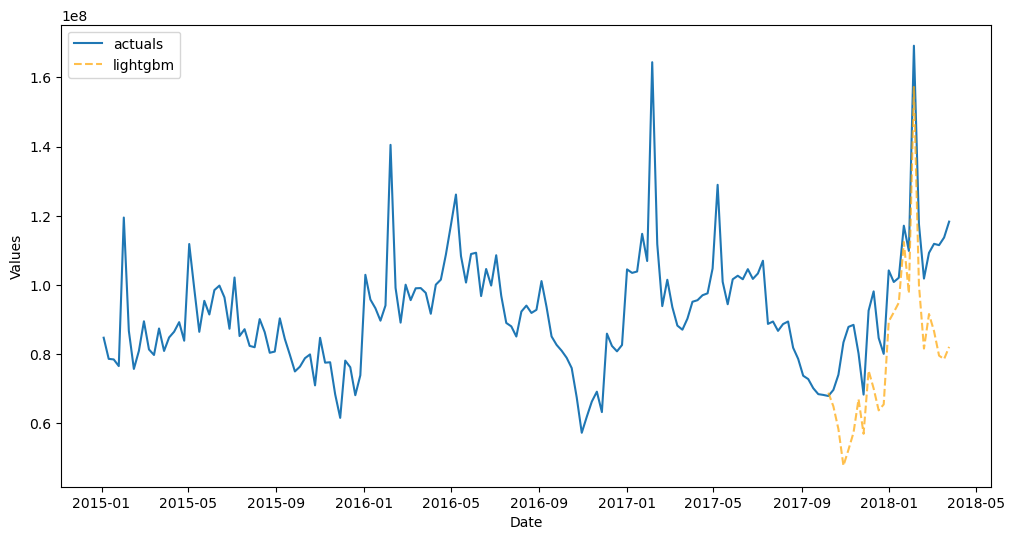

In [84]:
f_pipe.plot_test_set()
plt.show()

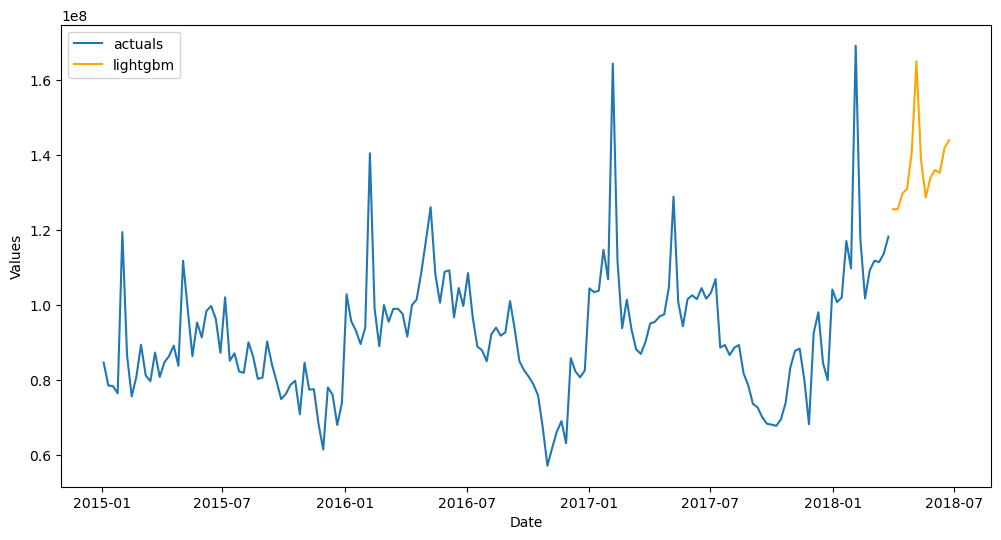

In [85]:
f_pipe.plot()
plt.show()

## Fully Automated Pipelines
- We can automate the construction of pipelines, the selection of input variables, and tuning of models with cross validation on a grid search for each model using files in the working directory called `Grids.py` for univariate forecasting and `MVGrids.py` for multivariate. Default grids can be downloaded from scalecast.

### Automated Univariate Pipelines
- [Documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Pipeline.html#src.scalecast.Pipeline.Pipeline)

In [86]:
from scalecast import GridGenerator
from scalecast.util import find_optimal_transformation

In [87]:
GridGenerator.get_example_grids(overwrite=True)

In [88]:
f_pipe_aut = Forecaster(y=volume,current_dates=volume.index,future_dates=13)
f_pipe_aut.set_test_length(.15)

In [89]:
def forecaster_aut(f,models):
    f.auto_Xvar_select(
        estimator='elasticnet',
        monitor='TestSetMAE',
        alpha=0.2,
        irr_cycles = [26],
    )
    f.tune_test_forecast(
        models,
        cross_validate=True,
        k=3,
        # dynamic tuning = 13 means we will hopefully find a model that is optimized to predict 13 steps
        dynamic_tuning=13,
        dynamic_testing=13,
    )
    f.set_estimator('combo')
    f.manual_forecast()

### util.find_optimal_transformation
In this function, the following transformations are searched for:  
- Detrending  
- Box-Cox  
- First Differencing  
- Seasonal Differencing  
- Scaling  

The optimal set of transformations are returned based on best estimated out-of-sample performance on the test set. Therefore, running this function introduces leakage into the test set, but it can still be a good addition to an automated pipeline, depending on the application. Which and the order of transfomations to search through are configurable. How performance is measured, the parameters specific to a given transformation, and several other paramters are also configurable. See the [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Util.html#module-src.scalecast.util.find_optimal_transformation).

In [90]:
transformer_aut, reverter_aut = find_optimal_transformation(
    f_pipe_aut,
    lags = 13,
    m = 52,
    monitor = 'mae',
    estimator = 'elasticnet',
    alpha = 0.2,
    test_length = 13,
    num_test_sets = 3,
    space_between_sets = 4,
    verbose = True,
) # returns a Transformer and Reverter object that can be plugged into a larger pipeline

All transformation tries will use 13 lags.
Last transformer tried:
[]
Score (mae): 17933061.20374991
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'loess': True})]
Score (mae): 23964157.165726673
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 1})]
Score (mae): 17174376.36667074
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 2})]
Score (mae): 24467364.037868027
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 1}), ('DeseasonTransform', {'m': 52, 'model': 'add'})]
Score (mae): 11573053.425807403
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 1}), ('DeseasonTransform', {'m': 52, 'model': 'add'}), ('DiffTransform', 1)]
Score (mae): 9478522.651025781
------------------------------------

In [91]:
pipeline_aut = Pipeline(
    steps = [
        ('Transform',transformer_aut),
        ('Forecast',forecaster_aut),
        ('Revert',reverter_aut),
    ]
)

f_pipe_aut = pipeline_aut.fit_predict(
    f_pipe_aut,
    models=[
        'mlr',
        'elasticnet',
        'xgboost',
        'lightgbm',
        'knn',
    ],
)

Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations


In [92]:
f_pipe_aut

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=13
    Xvars=['AR1', 'AR2', 'AR3', 'AR4', 'AR5']
    TestLength=25
    ValidationMetric=rmse
    ForecastsEvaluated=['mlr', 'elasticnet', 'xgboost', 'lightgbm', 'knn', 'combo']
    CILevel=None
    CurrentEstimator=combo
    GridsFile=Grids
)

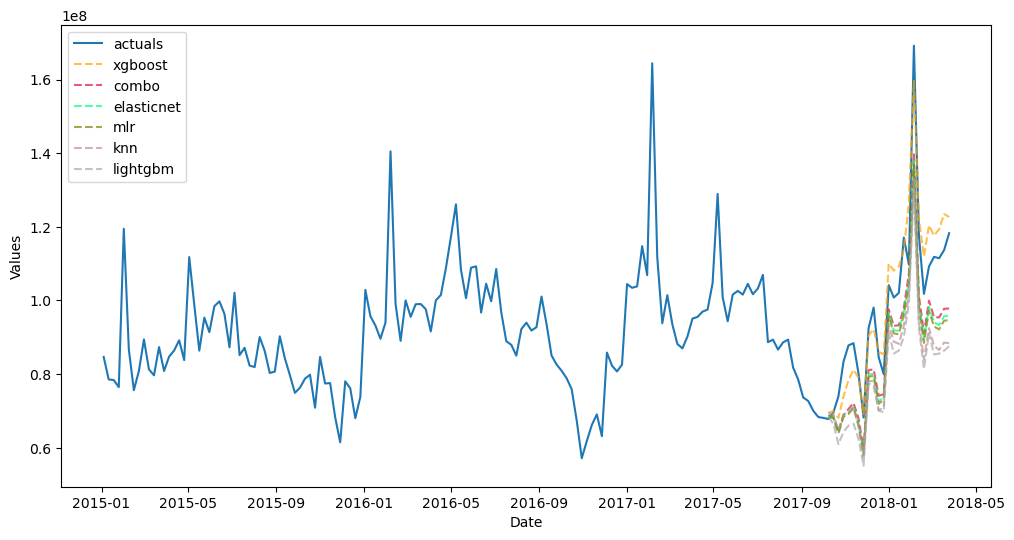

In [93]:
f_pipe_aut.plot_test_set(order_by='TestSetRMSE')
plt.show()

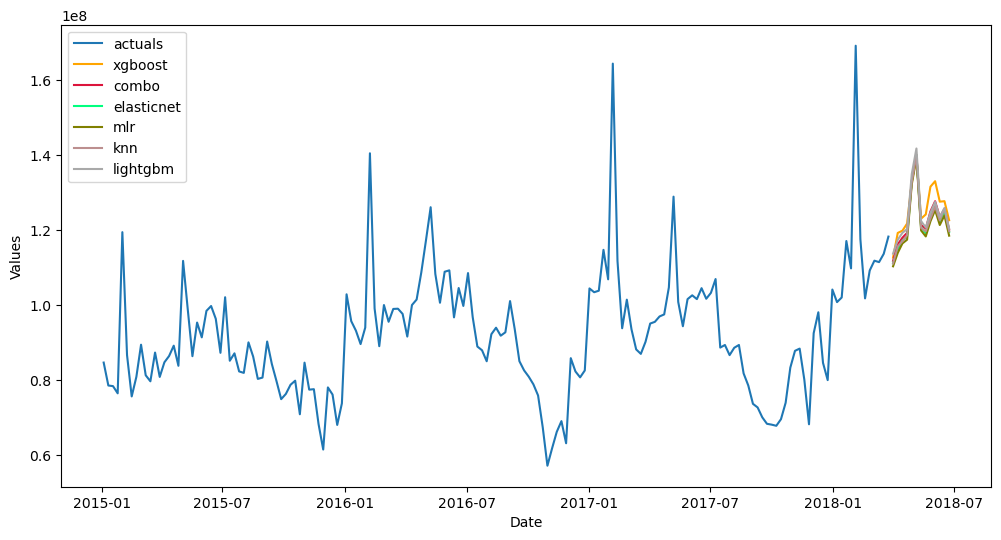

In [94]:
f_pipe_aut.plot(order_by='TestSetRMSE')
plt.show()

### Backtest Univariate Pipeline

You may be interested to know beyond a single test-set metric, how well your pipeline performs out-of-sample. Backtesting can help answer that by iterating through the entire pipeline several times and testing the procedure each time. It can also help make [expanding confidence intervals](https://scalecast-examples.readthedocs.io/en/latest/misc/cis-bt/cis-bt.html). See the [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Pipeline.html#src.scalecast.Pipeline.Pipeline.backtest).

In [95]:
from scalecast.util import backtest_metrics

In [96]:
uv_backtest_results = pipeline_aut.backtest(
    f_pipe_aut,
    n_iter = 3,
    jump_back = 13,
    cis = False,
    models=[
        'mlr',
        'elasticnet',
        'xgboost',
        'lightgbm',
        'knn',
    ],
)

Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations


After obtaining the results from the backtest, we can see the average performance over each iteration using the `util.backtest_metrics` function. See the [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Util.html#module-src.scalecast.util.backtest_metrics).

In [97]:
pd.options.display.float_format = '{:,.4f}'.format
backtest_metrics(
    uv_backtest_results,
    mets=['smape','rmse','bias'],
)

Iter0             Iter1            Iter2  \
Model      Metric                                                        
mlr        smape             0.1130            0.2317           0.1142   
           rmse     15,488,744.6687   19,538,227.8483  11,910,709.6300   
           bias   -165,115,026.5519 -207,268,257.9313 103,757,419.4097   
elasticnet smape             0.1237            0.1962           0.1428   
           rmse     16,732,592.7781   16,625,313.2954  14,338,412.2989   
           bias   -177,765,519.3932 -169,974,287.0231 145,808,728.0805   
xgboost    smape             0.0978            0.2221           0.1710   
           rmse     13,607,549.8360   18,573,088.5135  18,136,645.4700   
           bias   -139,025,946.3310 -187,065,120.1406 180,813,791.1197   
lightgbm   smape             0.1248            0.2178           0.1483   
           rmse     16,803,405.5145   18,415,746.1087  15,074,267.8093   
           bias   -176,880,323.1388 -195,683,280.2443 149,272,223.4129   
knn        smape             0.2044            0.1896           0.1439   
           rmse     23,802,323.7447   16,441,684.0561  14,418,665.8740   
           bias   -278,780,122.9043 -174,089,027.5994 145,204,593.3703   
combo      smape             0.1304            0.2109           0.1438   
           rmse     17,124,663.5858   17,869,415.4842  14,723,986.4866   
           bias   -187,513,387.6638 -186,815,994.5877 144,971,351.0786   

                            Average  
Model      Metric                    
mlr        smape             0.1529  
           rmse     15,645,894.0490  
           bias    -89,541,955.0245  
elasticnet smape             0.1542  
           rmse     15,898,772.7908  
           bias    -67,310,359.4453  
xgboost    smape             0.1636  
           rmse     16,772,427.9399  
           bias    -48,425,758.4506  
lightgbm   smape             0.1636  
           rmse     16,764,473.1442  
           bias    -74,430,459.9901  
knn        smape             0.1793  
           rmse     18,220,891.2249  
           bias   -102,554,852.3778  
combo      smape             0.1617  
           rmse     16,572,688.5189  
           bias    -76,452,677.0576

### Automated Multivariate Pipelines
- See the [MVPipeline object documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Pipeline.html#src.scalecast.Pipeline.MVPipeline).

In [98]:
GridGenerator.get_mv_grids(overwrite=True)

In [99]:
fvol_aut = Forecaster(
    y=volume,
    current_dates=volume.index,
    future_dates=13,
    test_length = .15,
)
fprice_aut = Forecaster(
    y=price,
    current_dates=price.index,
    future_dates=13,
    test_length = .15,
)

In [100]:
def add_vars(f,**kwargs):
    f.add_seasonal_regressors(
        'month',
        'quarter',
        'week',
        raw=False,
        sincos=True
    )

def mvforecaster(mvf,models):
    mvf.set_optimize_on('volume')
    mvf.tune_test_forecast(
        models,
        cross_validate=True,
        k=2,
        rolling=True,
        dynamic_tuning=13,
        dynamic_testing=13,
        limit_grid_size = .2,
        error = 'warn',
    )

In [101]:
transformer_vol, reverter_vol = find_optimal_transformation(
    fvol_aut,
    lags = 13,
    m = 52,
    monitor = 'mae',
    estimator = 'elasticnet',
    alpha = 0.2,
    test_length = 13,
    num_test_sets = 3,
    space_between_sets = 4,
    verbose = True,
)

All transformation tries will use 13 lags.
Last transformer tried:
[]
Score (mae): 17933061.20374991
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'loess': True})]
Score (mae): 23964157.165726673
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 1})]
Score (mae): 17174376.36667074
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 2})]
Score (mae): 24467364.037868027
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 1}), ('DeseasonTransform', {'m': 52, 'model': 'add'})]
Score (mae): 11573053.425807403
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 1}), ('DeseasonTransform', {'m': 52, 'model': 'add'}), ('DiffTransform', 1)]
Score (mae): 9478522.651025781
------------------------------------

In [102]:
transformer_price, reverter_price = find_optimal_transformation(
    fprice_aut,
    lags = 13,
    m = 52,
    monitor = 'mae',
    estimator = 'elasticnet',
    alpha = 0.2,
    test_length = 13,
    num_test_sets = 3,
    space_between_sets = 4,
    verbose = True,
)

All transformation tries will use 13 lags.
Last transformer tried:
[]
Score (mae): 0.06804292152560591
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'loess': True})]
Score (mae): 0.35311292233215247
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 1})]
Score (mae): 0.18654572266988656
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 2})]
Score (mae): 0.407907120834863
--------------------------------------------------
Last transformer tried:
[('DeseasonTransform', {'m': 52, 'model': 'add'})]
Score (mae): 0.04226554848615107
--------------------------------------------------
Last transformer tried:
[('DeseasonTransform', {'m': 52, 'model': 'add'}), ('Transform', <function find_optimal_transformation.<locals>.boxcox_tr at 0x7fcff088d040>, {'lmbda': -0.5})]
Score (mae): 0.047544210787943963
-----------------------

In [103]:
mvpipeline = MVPipeline(
    steps = [
        ('Transform',[transformer_vol,transformer_price]),
        ('Add Xvars',[add_vars]*2),
        ('Forecast',mvforecaster),
        ('Revert',[reverter_vol,reverter_price]),
    ],
    test_length = 20,
    cis = True,
    names = ['volume','price'],
)

fvol_aut, fprice_aut = mvpipeline.fit_predict(
    fvol_aut, 
    fprice_aut,
    models=[
        'mlr',
        'elasticnet',
        'xgboost',
        'lightgbm',
    ],
) # returns a tuple of Forecaster objects

Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations


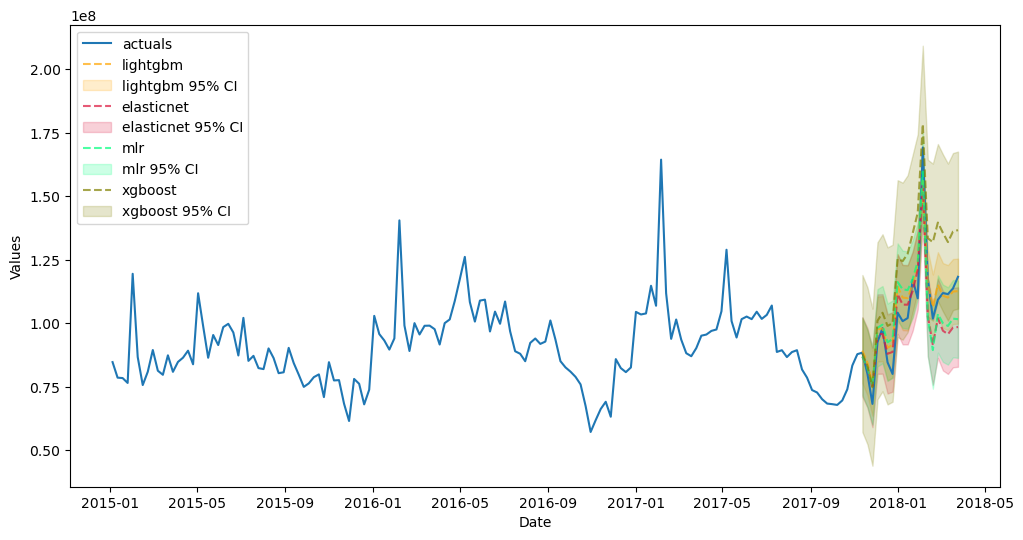

In [104]:
fvol_aut.plot_test_set(order_by='TestSetRMSE',ci=True)
plt.show()

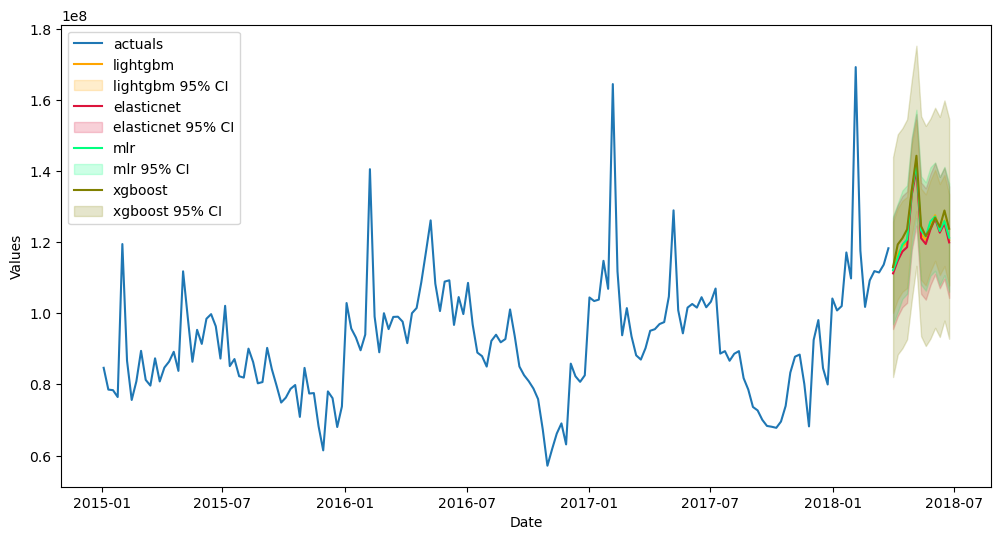

In [105]:
fvol_aut.plot(order_by='TestSetRMSE',ci=True)
plt.show()

### Backtest Multivariate Pipeline

Like univariate pipelines, multivariate pipelines can also be backtested. Info about each model and series becomes possible to compare. See the [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Pipeline.html#src.scalecast.Pipeline.MVPipeline.backtest).

In [106]:
# recreate Forecaster objects to bring dates back lost from taking seasonal differences
fvol_aut = Forecaster(
    y=volume,
    current_dates=volume.index,
    future_dates=13,
)
fprice_aut = Forecaster(
    y=price,
    current_dates=price.index,
    future_dates=13,
)

In [107]:
mv_backtest_results = mvpipeline.backtest(
    fvol_aut, 
    fprice_aut,
    n_iter = 3,
    jump_back = 13,
    test_length = 0,
    cis = False,
    models=[
        'mlr',
        'elasticnet',
        'xgboost',
        'lightgbm',
    ],
)

Finished loading model, total used 250 iterations
Finished loading model, total used 250 iterations
Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations
Finished loading model, total used 250 iterations
Finished loading model, total used 250 iterations


In [108]:
backtest_metrics(
    mv_backtest_results,
    mets=['smape','rmse','bias'],
    names = ['Volume','Price'],
)

Iter0             Iter1            Iter2  \
Series Model      Metric                                                        
Volume mlr        smape             0.0544            0.1176           0.1582   
                  rmse      9,607,094.0997   10,760,756.5379  15,963,833.7533   
                  bias    -69,742,732.2916  -87,711,912.6597 157,394,405.8767   
       elasticnet smape             0.0662            0.1606           0.1398   
                  rmse     10,759,298.7685   14,132,016.6443  14,134,913.2323   
                  bias    -82,997,021.2184 -139,537,507.0051 140,719,790.4827   
       xgboost    smape             0.1315            0.1447           0.0713   
                  rmse     20,090,059.9856   13,817,186.7925   7,510,114.4244   
                  bias    189,709,643.4190 -129,669,530.7265  71,329,272.6822   
       lightgbm   smape             0.1278            0.1161           0.1720   
                  rmse     16,974,627.6371   10,539,060.5819  17,427,536.4398   
                  bias   -182,115,273.5654  -76,693,584.9027 184,015,627.3148   
Price  mlr        smape             0.0523            0.0762           0.0808   
                  rmse              0.0811            0.1307           0.1782   
                  bias              0.9321            1.0663          -1.5867   
       elasticnet smape             0.0287            0.0606           0.1631   
                  rmse              0.0461            0.1043           0.2838   
                  bias             -0.1421            0.5670          -3.3627   
       xgboost    smape             0.0656            0.0513           0.1053   
                  rmse              0.1000            0.1024           0.2100   
                  bias              1.1779            0.1599          -2.2494   
       lightgbm   smape             0.0287            0.0630           0.1588   
                  rmse              0.0459            0.1215           0.2799   
                  bias             -0.2103           -0.1697          -3.2847   

                                  Average  
Series Model      Metric                   
Volume mlr        smape            0.1101  
                  rmse    12,110,561.4636  
                  bias       -20,079.6915  
       elasticnet smape            0.1222  
                  rmse    13,008,742.8817  
                  bias   -27,271,579.2469  
       xgboost    smape            0.1158  
                  rmse    13,805,787.0675  
                  bias    43,789,795.1249  
       lightgbm   smape            0.1386  
                  rmse    14,980,408.2196  
                  bias   -24,931,077.0511  
Price  mlr        smape            0.0698  
                  rmse             0.1300  
                  bias             0.1372  
       elasticnet smape            0.0841  
                  rmse             0.1447  
                  bias            -0.9793  
       xgboost    smape            0.0740  
                  rmse             0.1375  
                  bias            -0.3038  
       lightgbm   smape            0.0835  
                  rmse             0.1491  
                  bias            -1.2215

Through backtesting, we can see that the multivariate approach out-performed the univariate approach. Very cool!

## Scaled Automated Forecasting
- We can scale the fully automated approach to many series where we can then access all results through plotting with Jupyter widgets and export functions.
- We produce a separate forecast for avocado sales in each region in our dataset.
- This is done with a univariate approach, but cleverly using the code in this notebook, it could be transformed into a multivariate process where volume and price are forecasted together.

In [109]:
from scalecast.notebook import results_vis
from tqdm.notebook import tqdm

In [110]:
def forecaster_scaled(f,models):
    f.auto_Xvar_select(
        estimator='elasticnet',
        monitor='TestSetMAE',
        alpha=0.2,
        irr_cycles = [26],
    )
    f.tune_test_forecast(
        models,
        dynamic_testing=13,
    )
    f.set_estimator('combo')
    f.manual_forecast()

In [111]:
results_dict = {}
for region in tqdm(data.region.unique()):
    series = data.loc[data['region'] == region].groupby('Date')['Total Volume'].sum()
    f_i = Forecaster(
        y = series,
        current_dates = series.index,
        future_dates = 13,
        test_length = .15,
        validation_length = 13,
        cis = True,
    )
    transformer_i, reverter_i = find_optimal_transformation(
        f_i,
        lags = 13,
        m = 52,
        monitor = 'mae',
        estimator = 'elasticnet',
        alpha = 0.2,
        test_length = 13,
    )
    pipeline_i = Pipeline(
        steps = [
            ('Transform',transformer_i),
            ('Forecast',forecaster_scaled),
            ('Revert',reverter_i),
        ]
    )
    f_i = pipeline_i.fit_predict(
        f_i,
        models=[
            'mlr',
            'elasticnet',
            'xgboost',
            'lightgbm',
            'knn',
        ],
    )
    results_dict[region] = f_i

  0%|          | 0/54 [00:00<?, ?it/s]

Finished loading model, total used 250 iterations
Finished loading model, total used 250 iterations
Finished loading model, total used 250 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 250 iterations
Finished loading model, total used 250 iterations
Finished loading model, total used 250 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations
Finished loading model, total used 200 iterations
Finished loading model, total used 150 iterations
Finished loading model, total used 150 iterations


Run the next two functions locally to see the full functionality of these widgets.

In [112]:
results_vis(results_dict,'test')

Dropdown(description='Time Series:', options=('Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston', '…

Dropdown(description='No. Models', options=(1, 2, 3, 4, 5, 6), value=1)

Dropdown(description='View Confidence Intervals', options=(False, True), value=False)

Dropdown(description='Order By', index=7, options=('InSampleMAE', 'InSampleMAPE', 'InSampleR2', 'InSampleRMSE'…

Button(description='Select Time Series', style=ButtonStyle())

Output()

In [113]:
results_vis(results_dict)

Dropdown(description='Time Series:', options=('Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston', '…

Dropdown(description='No. Models', options=(1, 2, 3, 4, 5, 6), value=1)

Dropdown(description='View Confidence Intervals', options=(False, True), value=False)

Dropdown(description='Order By', index=7, options=('InSampleMAE', 'InSampleMAPE', 'InSampleR2', 'InSampleRMSE'…

Button(description='Select Time Series', style=ButtonStyle())

Output()

## Exporting Results

In [114]:
from scalecast.multiseries import export_model_summaries

### Exporting Results from a Single `Forecaster` Object

In [115]:
results = f.export(cis=True,models=['mlr','lasso','ridge'])
results.keys()

dict_keys(['model_summaries', 'lvl_fcsts', 'lvl_test_set_predictions'])

In [116]:
for k, df in results.items():
    print(f'{k} has these columns:',*df.columns,'-'*25,sep='\n')

model_summaries has these columns:
ModelNickname
Estimator
Xvars
HyperParams
Observations
DynamicallyTested
TestSetLength
CILevel
ValidationMetric
ValidationMetricValue
models
weights
best_model
InSampleRMSE
InSampleMAPE
InSampleMAE
InSampleR2
TestSetRMSE
TestSetMAPE
TestSetMAE
TestSetR2
-------------------------
lvl_fcsts has these columns:
DATE
mlr
mlr_upperci
mlr_lowerci
lasso
lasso_upperci
lasso_lowerci
ridge
ridge_upperci
ridge_lowerci
-------------------------
lvl_test_set_predictions has these columns:
DATE
actual
mlr
mlr_upperci
mlr_lowerci
lasso
lasso_upperci
lasso_lowerci
ridge
ridge_upperci
ridge_lowerci
-------------------------


In [117]:
results['model_summaries'][['ModelNickname','HyperParams','TestSetRMSE','InSampleRMSE']]

,ModelNickname,HyperParams,TestSetRMSE,InSampleRMSE
0,mlr,{},"16,818,489.5277","10,231,495.9303"
1,lasso,{'alpha': 0.2},"16,818,489.9828","10,231,495.9303"
2,ridge,{'alpha': 0.2},"16,827,165.4875","10,265,352.0145"


Other export functions:  
[Forecaster.export_Xvars_df](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.export_Xvars_df)   
[Forecaster.export_feature_importance](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.export_feature_importance)  
[Forecaster.export_fitted_vals](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.export_fitted_vals)  
[Forecaster.export_summary_stats](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.export_summary_stats)  
[Forecaster.export_validation_grid](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.export_validation_grid)  

Other plotting functions:  
[Forecaster.plot_fitted](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.plot_fitted)  
[Forecaster.plot_periodogram](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.plot_periodogram)  

### Exporting Results from a Single `MVForecaster` Object

In [118]:
mvresults = mvf.export(cis=True,models=['elasticnet','xgboost'])
mvresults.keys()

dict_keys(['model_summaries', 'lvl_fcsts', 'lvl_test_set_predictions'])

In [119]:
for k, df in mvresults.items():
    print(f'{k} has these columns:',*df.columns,'-'*25,sep='\n')

model_summaries has these columns:
Series
ModelNickname
Estimator
Xvars
HyperParams
Lags
Observations
DynamicallyTested
TestSetLength
ValidationMetric
ValidationMetricValue
OptimizedOn
MetricOptimized
best_model
InSampleRMSE
InSampleMAPE
InSampleMAE
InSampleR2
TestSetRMSE
TestSetMAPE
TestSetMAE
TestSetR2
-------------------------
lvl_fcsts has these columns:
DATE
volume_elasticnet_lvl_fcst
volume_elasticnet_lvl_fcst_upper
volume_elasticnet_lvl_fcst_lower
volume_xgboost_lvl_fcst
volume_xgboost_lvl_fcst_upper
volume_xgboost_lvl_fcst_lower
price_elasticnet_lvl_fcst
price_elasticnet_lvl_fcst_upper
price_elasticnet_lvl_fcst_lower
price_xgboost_lvl_fcst
price_xgboost_lvl_fcst_upper
price_xgboost_lvl_fcst_lower
-------------------------
lvl_test_set_predictions has these columns:
DATE
volume_actuals
volume_elasticnet_lvl_ts
volume_elasticnet_lvl_ts_upper
volume_elasticnet_lvl_ts_lower
volume_xgboost_lvl_ts
volume_xgboost_lvl_ts_upper
volume_xgboost_lvl_ts_lower
price_actuals
price_elasticnet_

In [120]:
mvresults['model_summaries'][['Series','ModelNickname','HyperParams','Lags','TestSetRMSE','InSampleRMSE']]

,Series,ModelNickname,HyperParams,Lags,TestSetRMSE,InSampleRMSE
0,volume,elasticnet,{'alpha': 0.2},13,"18,694,896.5159","11,976,031.0554"
1,volume,xgboost,{'gamma': 1},13,"22,606,056.1177",341.6022
2,price,elasticnet,{'alpha': 0.2},13,0.1522,0.1561
3,price,xgboost,{'gamma': 1},13,0.1292,0.1141


Other export functions:  
[Forecaster.export_fitted_vals](https://scalecast.readthedocs.io/en/latest/Forecaster/MVForecaster.html#src.scalecast.MVForecaster.MVForecaster.export_fitted_vals)   
[Forecaster.export_validation_grid](https://scalecast.readthedocs.io/en/latest/Forecaster/MVForecaster.html#src.scalecast.MVForecaster.MVForecaster.export_validation_grid)  

Other plotting functions:  
[MVForecaster.plot_fitted](https://scalecast.readthedocs.io/en/latest/Forecaster/MVForecaster.html#src.scalecast.MVForecaster.MVForecaster.plot_fitted)  

### Exporting Results from a Dictionary of `Forecaster` Objects

In [121]:
all_results = export_model_summaries(results_dict)
all_results[['ModelNickname','Series','Xvars','HyperParams','TestSetRMSE','InSampleRMSE']].sample(10)

,ModelNickname,Series,Xvars,HyperParams,TestSetRMSE,InSampleRMSE
178,knn,Northeast,"[AR1, AR2, AR3, AR4, AR5, AR6, AR7, AR8, AR9, ...",{'n_neighbors': 54},"724,041.5710","733,517.0246"
17,combo,BaltimoreWashington,None,{},"154,661.0027","140,291.4529"
56,xgboost,CincinnatiDayton,"[AR1, AR2, AR3, AR4, AR5, AR6, AR7, AR8, AR9, ...","{'n_estimators': 200, 'scale_pos_weight': 5, '...","29,716.4527","7,782.8633"
309,lightgbm,TotalUS,"[weeksin, weekcos, monthsin, monthcos, AR1, AR...","{'n_estimators': 250, 'boosting_type': 'dart',...","8,587,458.9970","15,516,549.5493"
115,elasticnet,Indianapolis,"[t, AR1, AR2, AR3, AR4, AR5, AR6, AR7, AR8, AR...","{'alpha': 2.0, 'l1_ratio': 0, 'normalizer': 'm...","61,612.3263","37,420.2720"
132,mlr,LosAngeles,"[weeksin, weekcos, monthsin, monthcos, quarter...",{'normalizer': 'scale'},"538,249.2891","450,855.7099"
23,combo,Boise,None,{},"12,828.5334","8,090.6574"
141,lightgbm,Louisville,"[weeksin, weekcos, monthsin, monthcos, AR1, AR...","{'n_estimators': 150, 'boosting_type': 'dart',...","17,403.8036","22,637.4852"
290,xgboost,StLouis,"[AR1, AR2, AR3, AR4, AR5, AR6, AR7, AR8, AR9, ...","{'n_estimators': 250, 'scale_pos_weight': 5, '...","44,612.6516",87.0324
112,knn,Houston,"[lnt, weeksin, weekcos, monthsin, monthcos, AR...",{'n_neighbors': 69},"298,081.3679","250,425.0721"
